# Modelo da MAV em forma de grafo para simulação com Nanorobôs

A MAV é representada em foram de grafo e um enxame de nanorobôs
é injetado na circulação para embolizar os vasos malformados.

In [27]:
# SPDX-License-Identifier: GPL-3.0-or-later
""" Modelo da MAV em forma de grafo para simulação com Nanorobôs.

.. codeauthor:: Carlo Oliveira <carlo@ufrj.br>

Changelog
---------

.. versionchanged::    21.07.b

    Reformat Jupyter with more cells

.. versionadded::    21.07.a

    Start data collection and tentative plotting

.. versionadded::    21.06.e

    Refactor out Embolize class

.. versionadded::    21.07.d

    Saving vases

.. versionadded::    21.06.c

    Grafo nanite e simulação da embolização

.. versionadded::    21.06.b

    Delimita mav e inicia criação de aresta

.. versionadded::    21.06.a

    Grafo nanite
"""
__version__ = "21.07.b"

## Caracterização de um Nó do Sistema Circulatório

Este Objeto caracteriza um nó entroncamento de vasos a ser usado no grafo do sistema circulatório.
Ele incorpora a capacidade de participar da simulação lidando com a passage de nanites por ele.
Ao passar por ele o nanite terá que obdecer a capacidade de fluxo deste nó.
O nanite receberá a características biofísicoquímicas do nó para ajustar o seu comportamento.

In [28]:
class Node:
    def __init__(self, env, syst, nome, ndepth, nmav):
        """ Nó construído para suportar o processo de simulação.

        :param env: Ambiente de simulação
        :param syst: Sistema circulatório que contem este nó.
        :param nome: Nome deste nó.
        :param ndepth: Profundidade corrente no grafo arterial.
        :param nmav: determina o nivél de marcadores de mav neste nó.
        """
        self.env, self.nome, self.depth, self.mav = env, nome, ndepth, nmav
        self.dest, self.cross, self.embolized = [], 0, 0
        self.flow = simpy.Resource(env, ndepth)
        """Capacidade de vazão deste nó, indo de grosso calibre a capilar"""
        syst.setdefault(ndepth, []).append(self)

    def add_edge(self, ndest):
        """ Adiciona uma vaso de saída neste entroncamento.

        :param ndest: Nó destino
        :return: None
        """
        self.dest.append(ndest)

    def set_edges(self, ndest):
        """ Substitui a coleção de vasos de saída neste entroncamento.

        :param ndest: lista de nós destino
        :return: None
        """
        self.dest = ndest

    def embolize(self):
        """ Emboliza este nó.

        :return: None
        """
        self.embolized += 1

    def cross_node(self, nanite):
        """ Atravessa um nanite por este nó.
        
        Ao passar pelo nó, o nanite terá que obedecer a capacidade de fluxo aqui presente.
        O nanite receberá as características biofísicoquímicas do nó para ajustar o seu comportamento.

        :param nanite: O nanite transeunte.
        :return: None
        """
        self.cross += 1
        # print("cross_node", nanite.name, self.ori, self.cross)
        yield self.env.process(nanite.cross_node(self.flow, self, self.dest, self.mav, self.depth))
        yield self.env.timeout(NODE_TRAVERSE)


## Caracterização do sistema circulatório e da MAV em forma de grafo

In [29]:
import simpy
import random
import statistics
import networkx as nx  # importing networkx package
import matplotlib.pyplot as plt  # importing matplotlib package and pyplot is for displaying the graph on canvas

NODE_TRAVERSE = 0.01
MAV_THRESHOLD = 5
NODEINFO = "node_info"
DEST = "destinations"
VASE_FILE = "artery_only.gpycle"

class Mav(nx.Graph):
    '''Gráfico MAV simulando a estrutura de vasos sanguíneos no cérebro.

    '''
    VASE_LEVEL = {}
    """Dicionário contendo todos os vasos ordenados pela distãncia do entroncamento"""
    def __init__(self, entry=8, mav_depth=6, graph_depth=7):
        """ Gráfico MAV simulando a estrutura de vasos sanguíneos no cérebro.

        :param env: Ambiente de simulação
        :param entry: capacidade de vazão do injetro de nanites.
        :param mav_depth: profundidade na rede onde se inicia uma malformção.
        :param graph_depth: profundidade da rede de vasos sanguíneos.
        """
        self.env = None #env
        super().__init__()
        self.node_name = 1
        """Inicia a nomeação dos nós com o número 1"""
        self.graph_depth = graph_depth
        self.mav_origin = False
        """Marcador do início da MAV no grafo."""
        self.mav_depth = mav_depth
        self.markers = "blue green yellow red yellow green".split()
        """Nível de concentração dos marcadores de MAV."""
        self.entry_node = None
        """Vaso onde os nanites foram injetados"""

    def do_edge(self, node, depth, mav=0):
        """ Criação de uma aresta representado um vaso sanguíneo

        :param node: O nó, que representa um entrroncamento de vasos.
        :param depth: profundidade corrente, decrementa ao avançar de nível.
        :param mav: determina o nivél de marcadores de mav neste nó
        :return: None
        """
        self.node_name += 1
        mav_depth = self.mav_depth
        name = self.node_name
        self.add_edge(node, name, depth=depth, mav=mav)
        self.nodes[name]['color'] = self.markers[mav]
        depth -= 1
        if (not self.mav_origin) and (depth < mav_depth):
            self.mav_origin = True
            mav = 1
        elif mav and (depth < mav_depth):
            mav += 1
        [self.do_edge(name, depth, mav=mav) for _ in range(0, random.randint(2, 3)) if depth]

    def embolized(self, threshold=1):
        """ Lista de nós embolizados.
        
        :return: Lista de nós embolizados
        """
        return [self.nodes[nd][NODEINFO].embolized
                                      for nd in self.nodes if self.nodes[nd][NODEINFO].embolized >= threshold]


    def redo_edge(self):
        """ Criação de um objeto Node para cada aresta representado um vaso sanguíneo com nó de processamento

        :return: None
        """
        env, sist = self.env, self.VASE_LEVEL


        for node_name in self.nodes: 
            node_depth, node_mav = self.nodes[node_name][NODEINFO]
            processing_node = Node(env, sist, node_name, node_depth, node_mav)
            self.nodes[node_name][NODEINFO] = processing_node
        for node_name in self.nodes: 
            self.nodes[node_name][NODEINFO].set_edges(
                [self.nodes[adjacent][NODEINFO] for adjacent in self.nodes[node_name][DEST]
                 if adjacent in self.nodes]) 

    def add_edge(self, ori, dest, depth, mav, **kwargs):
        """Adiciona uma aresta no NetworkX e cria uma classe Node para representar o destino.

        :param ori: Nó de origem.
        :param dest: nò de destino.
        :param depth: Profundidade corrente no grafo arterial.
        :param mav: determina o nivél de marcadores de mav neste nó.
        :param kwargs: Outros parâmetros auxiliares para ajutdar na plotagem.
        :return: None
        """
        super().add_edge(ori, dest, **kwargs)
        """Usa o add edge herdado do NetworkX"""
        node, ori_node = self.nodes[dest], self.nodes[ori]
        # return
        ori_node.setdefault(DEST,[]).append(dest)
        if NODEINFO not in ori_node:
            ori_node[NODEINFO] = (depth, mav)
        if NODEINFO not in node:
            node[NODEINFO] = (depth, mav)
            node.setdefault(DEST,[])


        # self.nodes[ori]["node"].add_edge(self.nodes[dest]["node"])

    def build(self, filename=VASE_FILE):
        """Constrói o grafo de maneira aleatória

        :return: None
        """
        self.do_edge(self.node_name, self.graph_depth)
        self.nodes[1]['color'] = "blue"
        nx.write_gpickle(self, filename)


    def load(self, env):
        """Recupera um grafo

        :return: None
        """
        self.env = env
        self.redo_edge()
        self.entry_node = self.nodes[1][NODEINFO]

    def plot(self):
        values = [self.nodes[node]["color"] for node in self.nodes()]

        nx.draw(self, with_labels=True, node_color=values)
        #  #draws the networkx graph containing nodes which are declared till before
        plt.show()  # displays the networkx graph on matplotlib canvas



## Caracterização do Nanorobô

In [30]:
        
class Nanite:
    def __init__(self, name, log, env, depth):
        """ O nanochip de embolização. Atualmente tem uma programação aleatória

        :param name: Identificador do chip.
        :param log: Método ao qual se deve reportar os eventos no trajeto.
        :param env: Ambiente de simulaçao.
        :param depth: Profundidade programada de embolização.
        """
        self.name, self.log, self.depth, self.env = name, log, depth, env
        self.mav, self.trs = 0, -1
        """Concentração de marcadores onde embolizou, nível de profundidade quando embolizou"""

    def cross_node(self, flow, current_node, destinations, mav, depth):
        """Atravessa um entrocamento de vasos, decidindo a ação a tomar.

        :param flow: capacidade de fluxo onde o nanite se encontra.
        :param current_node: Nó que está atravessando no momento.
        :param destinations: Listra dos possíveis destinos neste entroncamento.
        :param mav: Determina o nível de marcadores de mav neste nó.
        :param depth: Profundidade do nó que está atravessando no momento.
        :return:
        """
        if not self.depth:
            return
        with flow.request() as request:
            destination = 0
            yield request
            self.trs = depth
            if (depth <= self.depth) and mav:
                """estando na MAV e profundidade programada, para e emboliza"""
                self.mav = mav
                current_node.embolize()
                self.depth = 0
            elif destinations:
                destination = random.choice(destinations)
                yield self.env.process(destination.cross_node(self))
            self.log(self.name, current_node.nome, current_node.depth, current_node.mav,
                     destination.nome if destination else 0)


## Processo de Embolização

In [31]:
class Embolization:
    VASE_EVENT = {}
    """Dicionário de eventos da simulação indexado por nanaites"""
    def __init__(self, env, entry=8):
        """ Controlador do processo de embolização.

        :param env: Ambiente de simulação.
        :param entry: capacidade de vazão do injetor de nanites.
        """
        self.env = env
        """Ambiente de simulação"""
        self.swarm = []
        """Armazena todos os nanites injetados no sangue"""
        self.entry_point = simpy.Resource(env, entry)
        """capacidade de vazão da agulha injetora"""
        self.wait_times = []
        """tempos de percurso dos nanites"""

    def compute_event(self, nanite, node, level, mav, destination):
        """Computa eventos da travessia de um nanite por dentro da corrente sanguínea.
        
        Este método é injetado em cada nanite para que ele possa reportar os eventos do trajeto.
        
        :param nanite: Identificador do nanorobô que gerou o evento
        :param node: Identificador do nó circulatório onde o evento aconteceu.
        :param level: Nivel na árvore do nó circulatório onde o evento aconteceu.
        :param mav: Nível de marcadores de mav onde o evento aconteceu.
        :param destination: Identificador do nó circulatório para onde o nanorobô se dirige.
        """
        self.VASE_EVENT.setdefault(nanite, []).append(
            ((1000*self.env.now)//10, node, level, mav, destination))

    def go_to_mav(self, nanite):
        """Inicia a travessia de um nanite por dentro da corrente sanguínea.
        
        :param nanite: Identificador do nanorobô que gerou o evento
        """
        arrival_time = self.env.now

        with self.entry_point.request() as request:
            yield request
            # nanite_chip = Nanite(nanite, self.env, self.mav_depth)
            nanite_chip = Nanite(nanite, self.compute_event, self.env, MAV_THRESHOLD - random.randint(0, 5))
            self.swarm.append(nanite_chip)
            yield self.env.process(self.mav.entry_node.cross_node(nanite_chip))

        self.wait_times.append(self.env.now - arrival_time)
        """Armazena o intervalo de tempo atual na lista de intervalos"""

    def run_embolization(self, inital_nanites=3, nanite_interval=0.05):
        """ Executa o processo de embolização, injetando diversos nanites.

        :param inital_nanites:  Frente inicial de nanites injetados.
        :param nanite_interval: Intervalo para a injeção de um nanite
        :return: None
        """
        for nanite in range(inital_nanites):
            self.env.process(self.go_to_mav(nanite))

        while True:
            yield self.env.timeout(nanite_interval)  # Wait a bit before generating a new nanite

            nanite += 1
            self.env.process(self.go_to_mav(nanite))

    def get_average_wait_time(self):
        average_wait = statistics.mean(self.wait_times)
        minutes, frac_minutes = divmod(average_wait, 1)
        seconds = frac_minutes * 60
        return round(minutes), round(seconds)

    def count_embolizations(self):
        """ Retorna valores sobre a embolização

        :return: Número de Manites que embolizaram, número de nós embolizados.
        """
        # print(statistics.mean(nano.trs for nano in self.swarm))
        # print(self.entry_node.cross, [[k.ori for k in self.nodes[j]["node"].dest] for j in range(2, 6)])
        # print(self.entry_node.dest)
        return sum(1 for nano in self.swarm if nano.mav), len(self.swarm), sum(
            1 for nd in self.mav.embolized()
                   )

    def count_mav_rates(self):
        """Retorna estatísticas sobre a MAV embolizada

        :return: Nós embolizados, média de nanites embolizando o mesmo nó.
        """
        return sum(1 for nd in self.mav.embolized(0)
                   ), statistics.mean(self.mav.embolized())



    def main(self, simulation_time=200, build_mav=False):
        env = self.env
        mav = Mav(entry=self.entry_point)
        # random.seed(43)
        mav.build() if build_mav else None
        self.mav = mav = nx.read_gpickle(VASE_FILE)
        mav.load(env=env)
        # mav.plot() #descomente esta linha para plotar o grafo
        # [print(level, node.nome) for level, level_list in Mav.VASE_LEVEL.items() for node in level_list]
        # [print(level, [adj.nome for adj in node.dest]) for level, level_list in Mav.VASE_LEVEL.items() for node in level_list]
        # print (mav.adj)
        #return

        # Run the simulation
        env.process(self.run_embolization())
        env.run(until=simulation_time)

        # View the results
        mins, secs = self.get_average_wait_time()
        success, total, embolized = self.count_embolizations()
        mav_nodes, avg_embol = self.count_mav_rates()
        print(
          "Running simulation...",
          f"\nThe average wait time is {mins} minutes and {secs} seconds.",
          f"\nThe count of embolizing nanites is {success} over {total} total, {100*success/total: .2f}% efficient.",
          f"\nThe count of embolized vazes is {embolized} against exisiting {mav_nodes}  mav nodes.",
          f"\nThe process efficacy is {100*embolized/mav_nodes: .2f}% and over_embolization {avg_embol: .2f} average.",
        )
        event = {}
        for nanite, events in self.VASE_EVENT.items():
            [event.setdefault(eve[0], []).append(nanite) for eve in events]
        #print([len(nans) for nans in event.values()])
        #[print(f"nanite {nanite}, events {events}") for nanite, events in self.VASE_EVENT.items()]


## Relatório dos Resultados

Running simulation... 
The average wait time is 0 minutes and 3 seconds. 
The count of embolizing nanites is 17 over 42 total,  40.48% efficient. 
The count of embolized vazes is 10 against exisiting 277  mav nodes. 
The process efficacy is  3.61% and over_embolization  1.70 average.


<IPython.core.display.Javascript object>


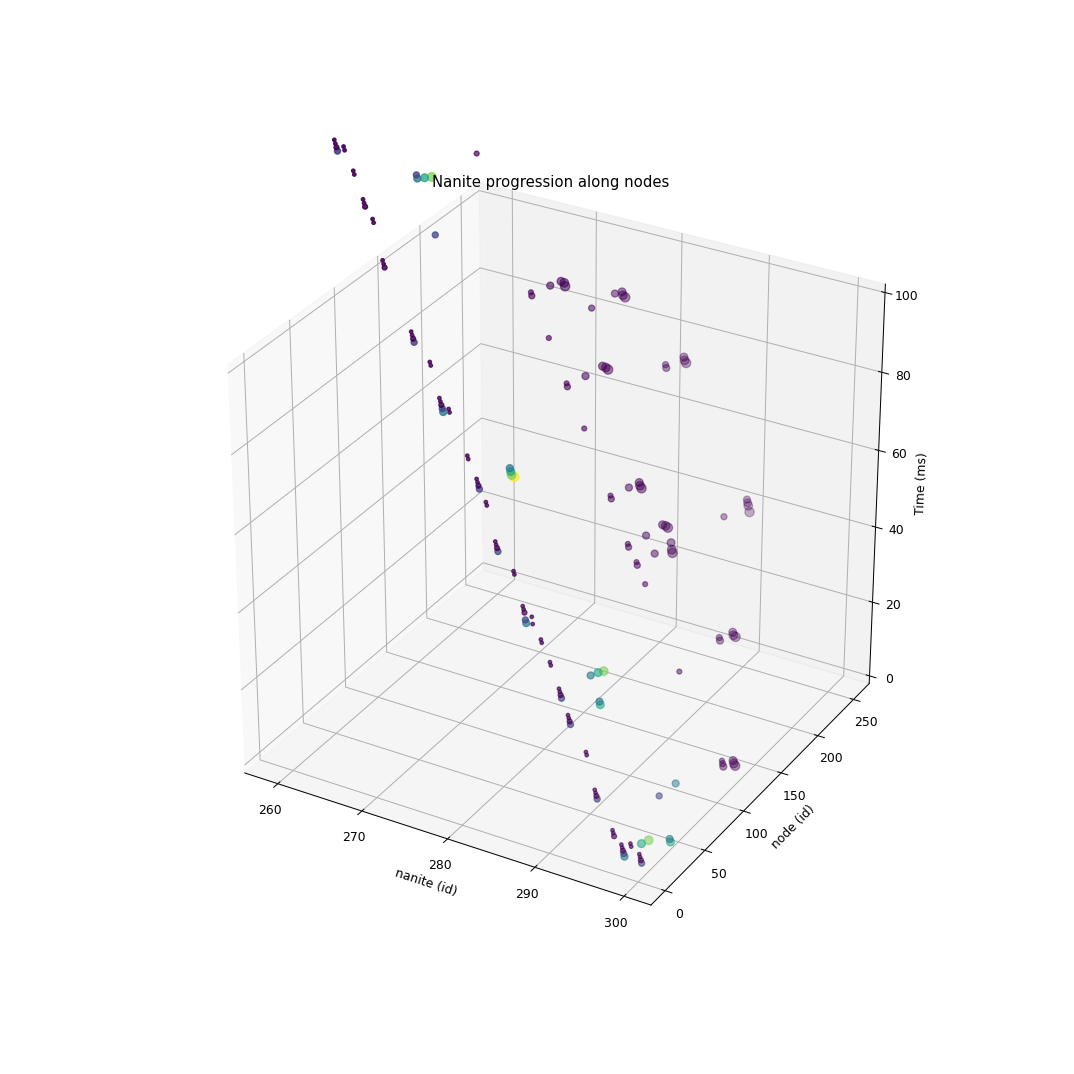

In [32]:
        
class ReportResults:
    """ Gera relatórios do processo de embolização.
    """
    def __init__(self, event):
        """ Gera relatórios do processo de embolização.
        
        :param event:  Dicionário de eventos recebido do processo de embolização.
        """
        self.VASE_EVENT = event
  
    def splot(self):
        %matplotlib notebook
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        import numpy as np
        #
        # Assuming you have "2D" dataset like the following that you need
        # to plot.
        #
        event = {}
        for nanite, events in self.VASE_EVENT.items():
            [event.setdefault(eve[0], []).append(nanite) for eve in events]
        evens = [(nanite, node, time, level, mav) for nanite, events in self.VASE_EVENT.items()
        for time, node, level, mav, *_ in events]
        nanite, node, time, level, mav = zip(*evens)
        level = [8*(8-lev) for lev in level]
        nanite = [300-lev for lev in nanite]
        fig = plt.figure()
        fig.set_size_inches(12, 12)
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs = nanite, ys = node, zs = time, c=mav, s=level)
        ax.set_title("Nanite progression along nodes")
        ax.set_xlabel("nanite (id)")
        ax.set_ylabel("node (id)")
        ax.set_zlabel("Time (ms)")
        ax.set_zlim(0,100)
        plt.show()
    
    def hplot(self):
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        import numpy as np
        event = {}
        for nanite, events in self.VASE_EVENT.items():
            [event.setdefault(eve[0], []).append(nanite) for eve in events]
        evens = [(nanite, node, time, level, mav) for nanite, events in self.VASE_EVENT.items()
        for time, node, level, mav, *_ in events]
        nanite, node, time, level, mav = zip(*evens)
        level = [8*(8-lev) for lev in level]
        nanite = [300-lev for lev in nanite]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        #
        # Create an X-Y mesh of the same dimension as the 2D data. You can
        # think of this as the floor of the plot.
        #
        x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                                      np.arange(data_array.shape[0]) )
        #
        # Flatten out the arrays so that they may be passed to "ax.bar3d".
        # Basically, ax.bar3d expects three one-dimensional arrays:
        # x_data, y_data, z_data. The following call boils down to picking
        # one entry from each array and plotting a bar to from
        # (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
        #
        x_data = time
        y_data = nanite
        z_data = data_array.flatten()
        ax.bar3d( x_data,
                  y_data,
                  np.zeros(len(z_data)),
                  1, 1, z_data )
        #
        # Finally, display the plot.
        #
        plt.show()
        
    def h3dplot(self):
        import numpy as np
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        from matplotlib import cm
        evens = [(nanite, node, time, level, mav) for nanite, events in self.VASE_EVENT.items()
                for time, node, level, mav, *_ in events]
        '''
        event = {}
        for nanite, events in self.VASE_EVENT.items():
            [event.setdefault(eve[0], []).append(nanite) for eve in events]
        nanite, node, time, level, mav = zip(*evens)
        level = [8*(8-lev) for lev in level]
        time = [int(tm) for tm in time]
        # nanite = [300-lev for lev in nanite]
        result=[[0]*len(time)]*len(nanite)
        '''
        for nanite, event in self.VASE_EVENT.items():
            for time, node, level, mav, *_ in event:
                #print(nanite, time, node, level, mav)
                result[nanite][int(time)] = level
                [print(lv[:30]) for lv in result[:30]]
        return
        result = np.array(result, dtype=np.int)

        fig=plt.figure(figsize=(5, 5), dpi=150)
        ax1=fig.add_subplot(111, projection='3d')

        xlabels = np.array(time)
        xpos = np.arange(xlabels.shape[0])
        ylabels = np.array(nanite)
        ypos = np.arange(ylabels.shape[0])

        xposM, yposM = np.meshgrid(xpos, ypos, copy=False)

        zpos=result
        zpos = zpos.ravel()

        dx=0.5
        dy=0.5
        dz=zpos

        #ax1.w_xaxis.set_ticks(xpos + dx/2.)
        #ax1.w_xaxis.set_ticklabels(xlabels)

        #ax1.w_yaxis.set_ticks(ypos + dy/2.)
        #ax1.w_yaxis.set_ticklabels(ylabels)

        values = np.linspace(0.2, 1., xposM.ravel().shape[0])
        colors = cm.rainbow(values)
        ax1.bar3d(xposM.ravel(), yposM.ravel(), dz*0, dx, dy, dz, color=colors)
        plt.show()
        
        
def main():
    env = simpy.Environment()
    embolization = Embolization(env=env)
    embolization.main(2, 0)
    ReportResults(Embolization.VASE_EVENT).splot()
    #embolization.h3dplot()


main()
